In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans, HDBSCAN
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from sklearn.decomposition import PCA

In [27]:
folder = '../../../data/config/clusters/'
clusters = ['HH', 'HL', 'LH', 'LL']
scale_factors = [1000, 1000, 0.0002]

In [28]:
from scipy.stats import truncnorm

def truncated_normal_noise(x, stds):
    # a, b are the bounds for truncation in standard deviations
    x = np.asarray(x)
    stds = np.asarray(stds)
    a = (0 - x) / stds
    b = (np.inf - x) / stds
    noise = truncnorm.rvs(a, b, loc=0, scale=stds)
    return x + noise

df_list = []

# CREO CLUSTER GAUSSIANI AD HOC
#for cluster in clusters:
#    first_point = pd.read_csv(folder + f'cluster_{cluster}.csv').iloc[0].values
#    gauss_points = [truncated_normal_noise(x=first_point, stds=[0.0001,0.0001,1]) for _ in range(1000)]
#    df = pd.DataFrame.from_records(gauss_points, columns=['r0', 'r1', 'c1'])
#    df['region'] = cluster
#    df_list.append(df)

In [29]:
df_list = []

for cluster in clusters:
    points = pd.read_csv(folder + f'cluster_{cluster}.csv')
    df = pd.DataFrame.from_records(points)
    df['region'] = cluster
    df_list.append(df)

/var/folders/2j/2mbkhb5n5fg0fn1t37btqv140000gn/T/ipykernel_64347/3323733553.py:5: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(points)
/var/folders/2j/2mbkhb5n5fg0fn1t37btqv140000gn/T/ipykernel_64347/3323733553.py:5: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(points)
/var/folders/2j/2mbkhb5n5fg0fn1t37btqv140000gn/T/ipykernel_64347/3323733553.py:5: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(points)
/var/folders/2j/2mbkhb5n5fg0fn1t37btqv140000gn/T/ipykernel_64347/3323733553.py:5: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd

In [30]:
df

,r0,r1,c1,region
0,0.004415,0.007274,6123.883917,LL
1,0.004403,0.007262,6147.566596,LL
2,0.006612,0.005086,15119.873595,LL
3,0.004402,0.007264,6143.487356,LL
4,0.004401,0.007264,6141.861339,LL
...,...,...,...,...
96,0.004402,0.007264,6142.886778,LL
97,0.004403,0.007262,6142.439971,LL
98,0.004874,0.006809,7298.844249,LL
99,0.004401,0.007265,6142.169690,LL


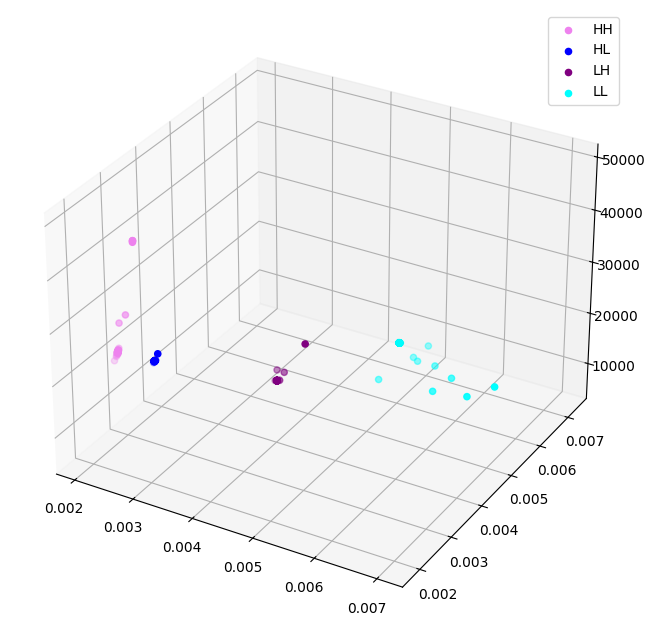

In [31]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_list[0]['r0'], df_list[0]['r1'], df_list[0]['c1'], color='violet', label=clusters[0])
ax.scatter(df_list[1]['r0'], df_list[1]['r1'], df_list[1]['c1'], color='blue', label=clusters[1])
ax.scatter(df_list[2]['r0'], df_list[2]['r1'], df_list[2]['c1'], color='purple', label=clusters[2])
ax.scatter(df_list[3]['r0'], df_list[3]['r1'], df_list[3]['c1'], color='cyan', label=clusters[3])

ax.legend()

In [32]:
df = pd.concat(df_list, ignore_index=True)

# Shuffle the rows
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [33]:
df

,r0,r1,c1,region
0,0.002197,0.002481,22950.955827,HH
1,0.004018,0.003998,15232.179845,LH
2,0.004406,0.007260,6150.195291,LL
3,0.002198,0.002479,22977.220017,HH
4,0.002211,0.002462,23255.565439,HH
...,...,...,...,...
399,0.002202,0.002476,23061.605430,HH
400,0.002598,0.002847,20490.503319,HL
401,0.004018,0.003999,15220.328522,LH
402,0.005402,0.006484,9168.792689,LL


## K-means analysis

In [34]:
df_kmeans = df.copy()

# Encode labels and prepare data
label_mapping = {label: idx for idx, label in enumerate(df_kmeans["region"].unique())}
true_labels = df_kmeans["region"].map(label_mapping).values

In [35]:
# Normalize features (drop non-numeric and target columns)
X = df_kmeans.drop(columns=["region"])
X = X.select_dtypes(include=["number"])  # Only numeric columns

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [36]:
# Run K-Means with correct number of clusters
kmeans = KMeans(n_clusters=len(label_mapping), random_state=42, n_init="auto")
kmeans_predictions = kmeans.fit_predict(X_scaled)

In [37]:
# Evaluate clustering
ari_score = adjusted_rand_score(true_labels, kmeans_predictions)
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")

Adjusted Rand Index (ARI): 0.6992


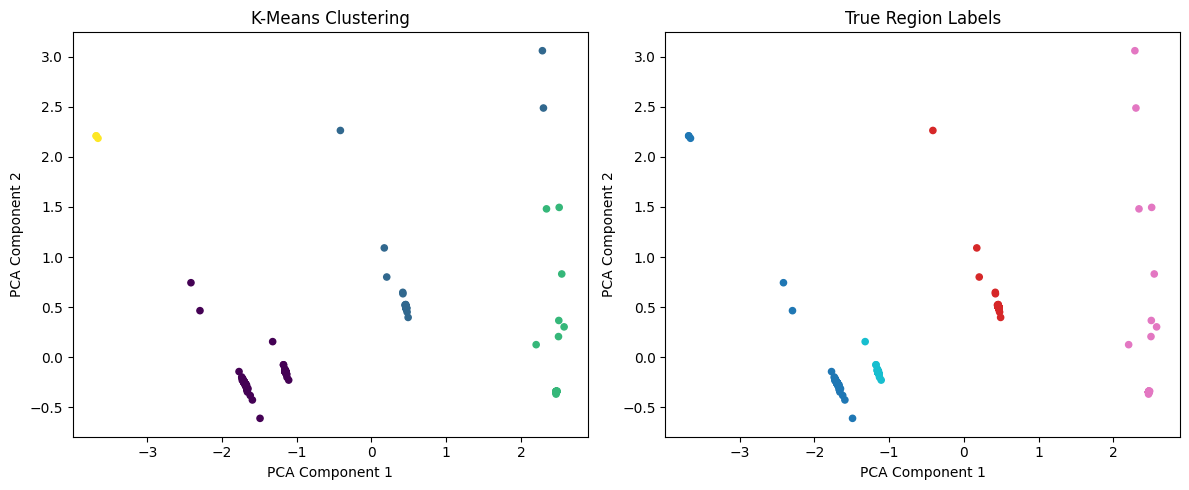

In [38]:
# Reduce dimensionality to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot predicted clusters
plt.figure(figsize=(12, 5))

# Plot K-Means clustering result
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_predictions, cmap='viridis', s=20)
plt.title("K-Means Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Plot true region labels
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=true_labels, cmap='tab10', s=20)
plt.title("True Region Labels")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

plt.tight_layout()
plt.show()

In [39]:
# Add predicted labels to DataFrame
df_kmeans['k-means_label'] = kmeans_predictions
df_kmeans['true_label'] = true_labels

# Create a confusion matrix
conf_mat = confusion_matrix(df_kmeans['true_label'], df_kmeans['k-means_label'])

# Calculate errors per cluster
errors = []
for cluster_id in range(conf_mat.shape[1]):
    total = conf_mat[:, cluster_id].sum()
    correct = conf_mat[cluster_id, cluster_id] if cluster_id < conf_mat.shape[0] else 0
    error = 1 - (correct / total) if total > 0 else 0
    errors.append(error)

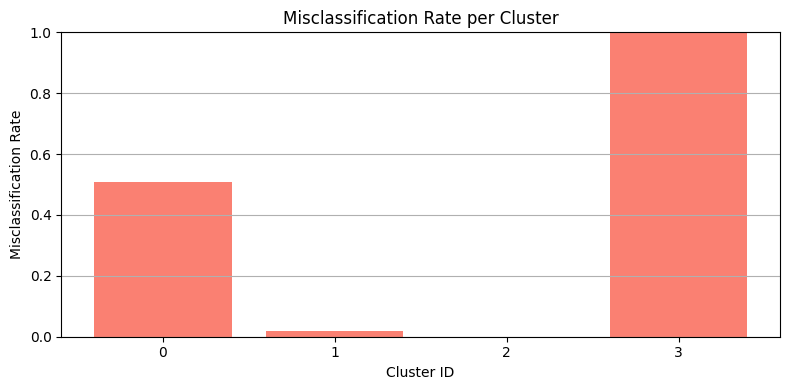

In [40]:
# Plot
plt.figure(figsize=(8, 4))
plt.bar(range(len(errors)), errors, color='salmon')
plt.xlabel('Cluster ID')
plt.ylabel('Misclassification Rate')
plt.title('Misclassification Rate per Cluster')
plt.xticks(range(len(errors)))
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [41]:
df_kmeans

,r0,r1,c1,region,k-means_label,true_label
0,0.002197,0.002481,22950.955827,HH,0,0
1,0.004018,0.003998,15232.179845,LH,1,1
2,0.004406,0.007260,6150.195291,LL,2,2
3,0.002198,0.002479,22977.220017,HH,0,0
4,0.002211,0.002462,23255.565439,HH,0,0
...,...,...,...,...,...,...
399,0.002202,0.002476,23061.605430,HH,0,0
400,0.002598,0.002847,20490.503319,HL,0,3
401,0.004018,0.003999,15220.328522,LH,1,1
402,0.005402,0.006484,9168.792689,LL,2,2


## DBSCAN analysis

In [42]:
df_dbscan = None
df_dbscan = df.copy()

# Encode the 'region' label
label_encoder = LabelEncoder()
df_dbscan['true_label'] = label_encoder.fit_transform(df_dbscan['region'])
true_labels = df_dbscan['true_label']

# Select features and normalize
features = df_dbscan[['r0', 'r1', 'c1']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [43]:
dbscan = DBSCAN(eps=0.3, min_samples=5)  # adjust eps and min_samples as needed
dbscan_predictions = dbscan.fit_predict(X_scaled)

# Add to dataframe
df_dbscan['dbscan_label'] = dbscan_predictions

In [44]:
# Filter out noise points
filtered_df = df_dbscan[df_dbscan['dbscan_label'] != -1]
conf_mat = confusion_matrix(filtered_df['true_label'], filtered_df['dbscan_label'])

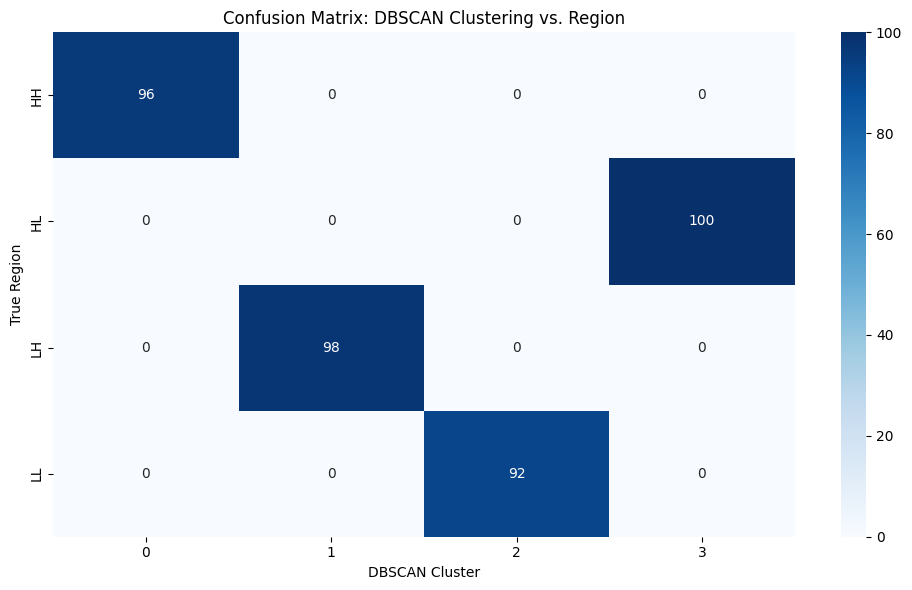

In [45]:
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(filtered_df['dbscan_label']),
            yticklabels=label_encoder.classes_)
plt.xlabel("DBSCAN Cluster")
plt.ylabel("True Region")
plt.title("Confusion Matrix: DBSCAN Clustering vs. Region")
plt.tight_layout()
plt.show()

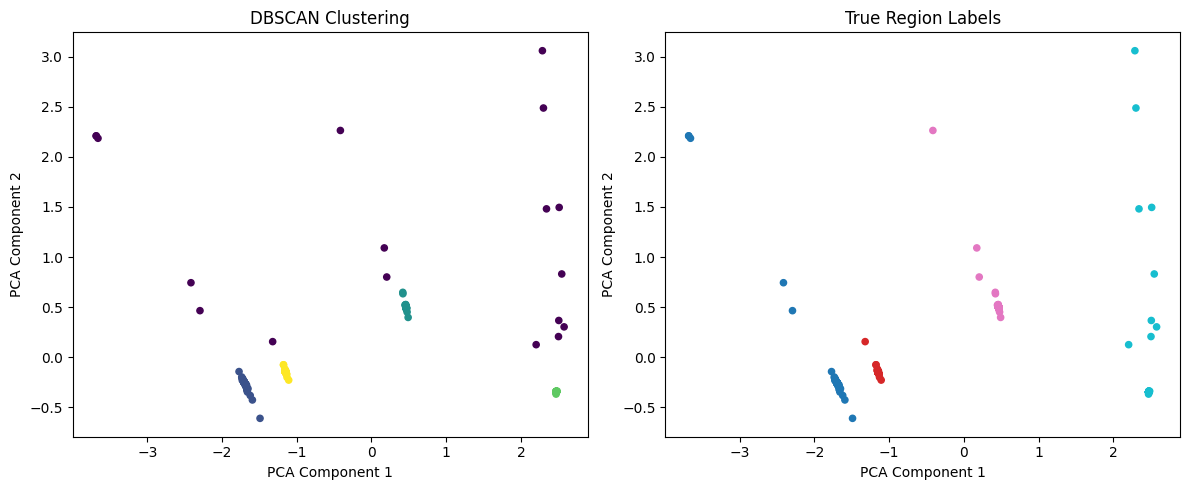

In [46]:
# Reduce dimensionality to 2D for visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

df_dbscan['x'] = X_2d[:, 0]
df_dbscan['y'] = X_2d[:, 1]

# -1 is noise (DBSCAN label for outliers), so we can skip or include as needed
df_dbscan['is_misclassified'] = (
    (df_dbscan['dbscan_label'] != -1) &
    (df_dbscan['true_label'] != df_dbscan['dbscan_label'])
)

# Plot predicted clusters
plt.figure(figsize=(12, 5))

# Plot DBSCAN clustering result
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_predictions, cmap='viridis', s=20)
plt.title("DBSCAN Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Plot true region labels
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=true_labels, cmap='tab10', s=20)
plt.title("True Region Labels")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

plt.tight_layout()
plt.show()

In [47]:
sum(df_dbscan['dbscan_label'] == -1)

18

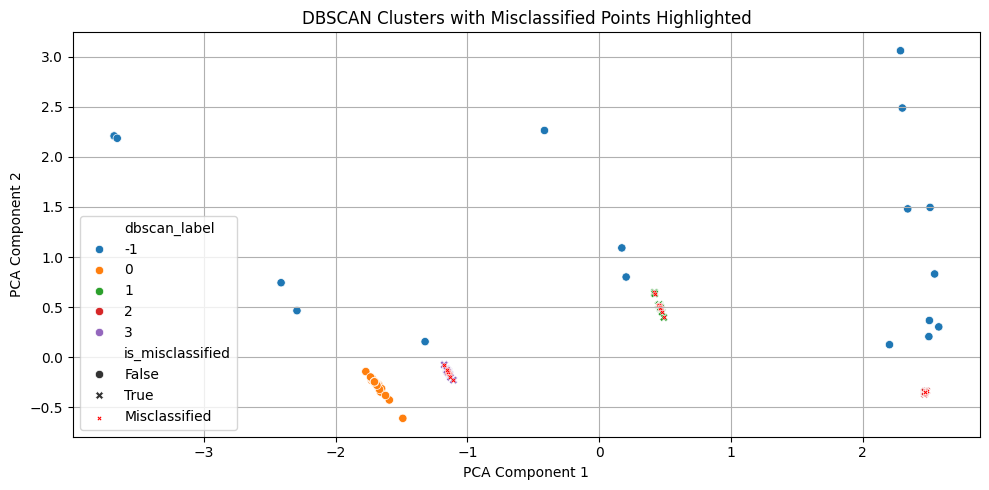

In [48]:
plt.figure(figsize=(10, 5))

# Plot correctly classified
sns.scatterplot(
    data=df_dbscan[~df_dbscan['is_misclassified'] & df_dbscan['dbscan_label'] != -1],
    x='x', y='y',
    hue='dbscan_label',
    palette='tab10',
    style='is_misclassified',
    alpha=1,
    legend=True
)

# Plot misclassified
sns.scatterplot(
    data=df_dbscan[df_dbscan['is_misclassified']],
    x='x', y='y',
    color='red',
    marker='X',
    label='Misclassified',
    s=10
)


plt.title('DBSCAN Clusters with Misclassified Points Highlighted')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
for label in [-1,0,1,2,3]:
    print("Cluster {}: {}".format(label, len(df_dbscan[df_dbscan['dbscan_label'] == label])))

Cluster -1: 18
Cluster 0: 96
Cluster 1: 98
Cluster 2: 92
Cluster 3: 100


In [50]:
df_no_outliers = df_dbscan[df_dbscan['dbscan_label'] != -1]

from scipy.stats import shapiro
from sklearn.decomposition import PCA

for label in df_no_outliers['region'].unique():
    subset = df_no_outliers[df_no_outliers['region'] == label].drop(columns=['region'])
    subset = subset[['r0', 'r1', 'c1']]
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(subset)

    print(f"Cluster {label}")
    for i in range(3):
        stat, p = shapiro(reduced[:, i])
        print(f"  PC{i+1}: p-value={p}")

Cluster HH
  PC1: p-value=3.1190919043566544e-15
  PC2: p-value=2.784905426014344e-10


IndexError: index 2 is out of bounds for axis 1 with size 2

In [51]:
subset

,r0,r1,c1
0,0.002197,0.002481,22950.955827
3,0.002198,0.002479,22977.220017
4,0.002211,0.002462,23255.565439
5,0.002195,0.002483,22944.431260
11,0.002199,0.002478,23005.351300
...,...,...,...
377,0.002199,0.002479,22992.920276
390,0.002197,0.002480,22955.111654
392,0.002186,0.002489,22779.350121
397,0.002201,0.002477,23038.603730


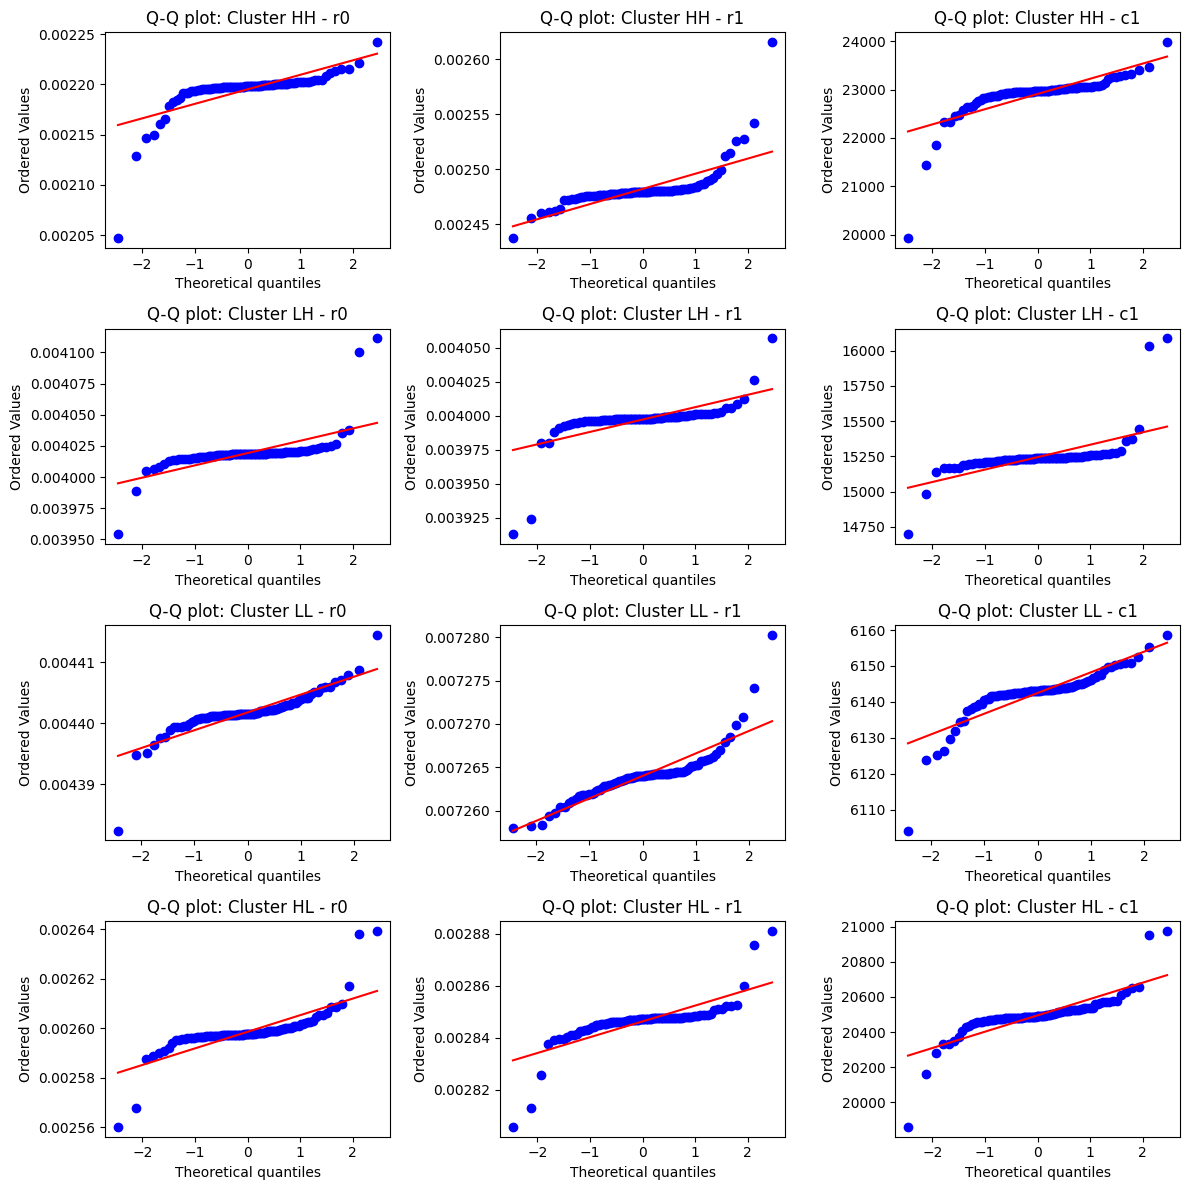

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot

fig, axes = plt.subplots(4, 3, figsize=(12,12))

for i, label in enumerate(df_no_outliers['region'].unique()):
    subset = df_no_outliers[df_no_outliers['region'] == label].drop(columns=['region'])
    for j, col in enumerate(['r0', 'r1', 'c1']):
        probplot(subset[col], dist="norm", plot=axes[i][j])
        axes[i][j].set_title(f'Q-Q plot: Cluster {label} - {col}')

plt.tight_layout()

## HDBSCAN

In [53]:
df_hdb = None
df_hdb = df.copy()

# Encode the 'region' label
label_encoder = LabelEncoder()
df_hdb['true_label'] = label_encoder.fit_transform(df_hdb['region'])
true_labels = df_hdb['true_label']

# Select features and normalize
features = df_hdb[['r0', 'r1', 'c1']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [54]:
hdb = HDBSCAN(min_cluster_size=60)
hdb_predictions = hdb.fit_predict(X_scaled)

In [55]:
# Add to dataframe
df_hdb['hdb_label'] = hdb_predictions

In [56]:
df_hdb

,r0,r1,c1,region,true_label,hdb_label
0,0.002197,0.002481,22950.955827,HH,0,2
1,0.004018,0.003998,15232.179845,LH,2,1
2,0.004406,0.007260,6150.195291,LL,3,0
3,0.002198,0.002479,22977.220017,HH,0,2
4,0.002211,0.002462,23255.565439,HH,0,2
...,...,...,...,...,...,...
399,0.002202,0.002476,23061.605430,HH,0,2
400,0.002598,0.002847,20490.503319,HL,1,3
401,0.004018,0.003999,15220.328522,LH,2,1
402,0.005402,0.006484,9168.792689,LL,3,0


In [57]:
# Filter out noise points
filtered_df = df_hdb[df_hdb['hdb_label'] != -1]
conf_mat = confusion_matrix(filtered_df['true_label'], filtered_df['hdb_label'])

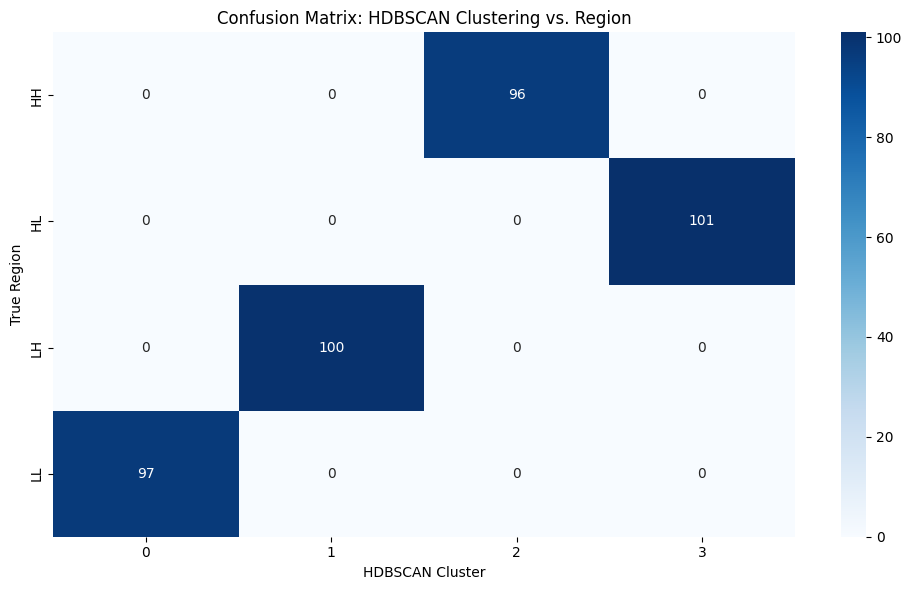

In [58]:
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(filtered_df['hdb_label']),
            yticklabels=label_encoder.classes_)
plt.xlabel("HDBSCAN Cluster")
plt.ylabel("True Region")
plt.title("Confusion Matrix: HDBSCAN Clustering vs. Region")
plt.tight_layout()
plt.show()

## Shapiro-Wilk test

In [59]:
from scipy.stats import shapiro
from sklearn.decomposition import PCA

for label in df['region'].unique():
    subset = df[df['region'] == label].drop(columns=['region'])
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(subset)

    print(f"Cluster {label}")
    for i in range(2):
        stat, p = shapiro(reduced[:, i])
        print(f"  PC{i+1}: p-value={p}")

Cluster HH
  PC1: p-value=3.0965437669955864e-20
  PC2: p-value=8.363907386769866e-15
Cluster LH
  PC1: p-value=2.62162128045915e-21
  PC2: p-value=2.084095411786246e-18
Cluster LL
  PC1: p-value=2.5635023153122377e-20
  PC2: p-value=2.0851408783472507e-19
Cluster HL
  PC1: p-value=1.7914590229427856e-19
  PC2: p-value=9.056753661766166e-14


## Gaussian Mixture Models

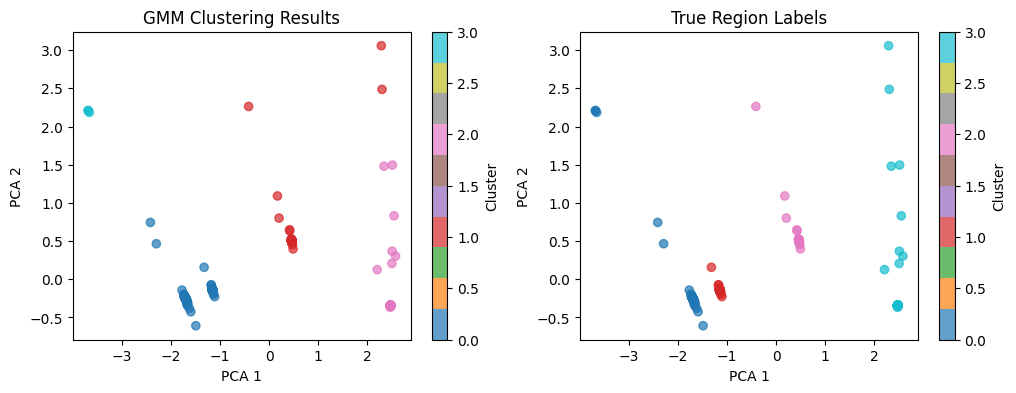

In [32]:
from sklearn.mixture import GaussianMixture

df_gmm = None
df_gmm = df.copy()

# Encode the 'region' label
label_encoder = LabelEncoder()
df_gmm['true_label'] = label_encoder.fit_transform(df_gmm['region'])
true_labels = df_gmm['true_label']

# Example: Assume `df` is your DataFrame with features
X = df_gmm[['r0', 'r1', 'c1']]

# Optional: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit GMM
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
gmm.fit(X_scaled)
labels = gmm.predict(X_scaled)

# Add labels back to the DataFrame
df['gmm_cluster'] = labels

# Plot with PCA (or use TSNE/UMAP if higher-dim)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.title("GMM Clustering Results")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label='Cluster')

plt.subplot(1, 2, 2)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=true_labels, cmap='tab10', alpha=0.7)
plt.title("True Region Labels")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label='Cluster')

plt.show()

## Mahalanobis distance distribution

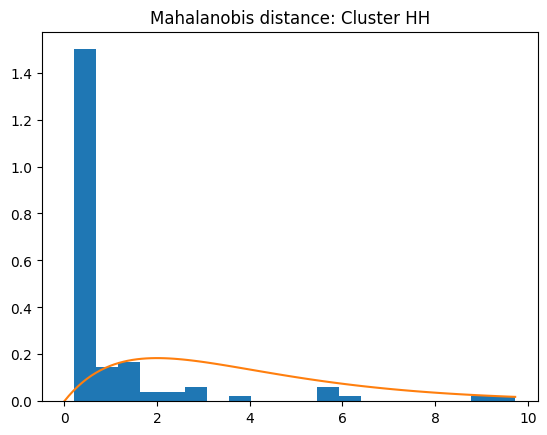

LinAlgError: Singular matrix

In [33]:
from scipy.stats import chi2
from scipy.spatial.distance import mahalanobis
import numpy as np

for label in df['region'].unique():
    subset = df[df['region'] == label].drop(columns=['region'])
    mean = np.mean(subset, axis=0)
    cov = np.cov(subset.T)
    inv_cov = np.linalg.inv(cov)
    
    distances = [mahalanobis(x, mean, inv_cov) for x in subset.values]
    plt.hist(distances, bins=20, density=True)
    x = np.linspace(0, max(distances), 100)
    plt.plot(x, chi2.pdf(x, df=subset.shape[1]))  # compare with chi-squared
    plt.title(f'Mahalanobis distance: Cluster {label}')
    plt.show()

## Q-Q plots

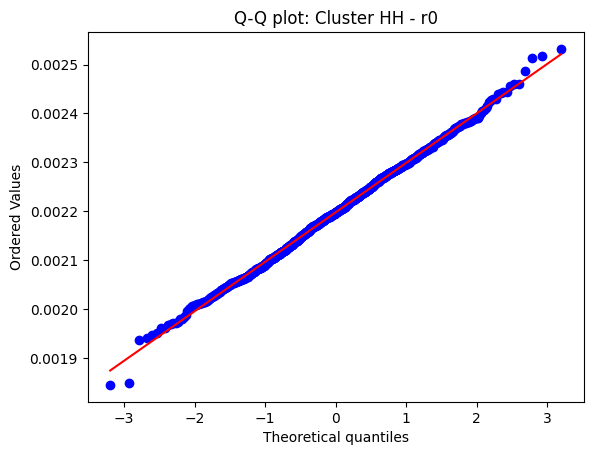

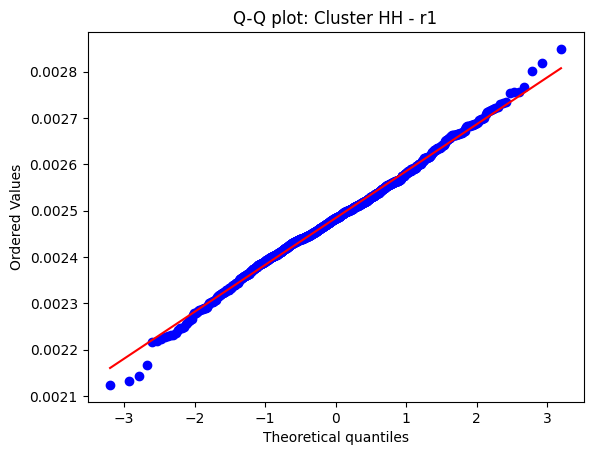

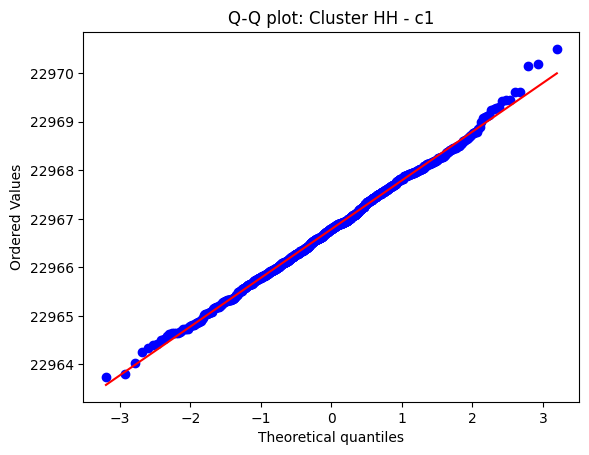

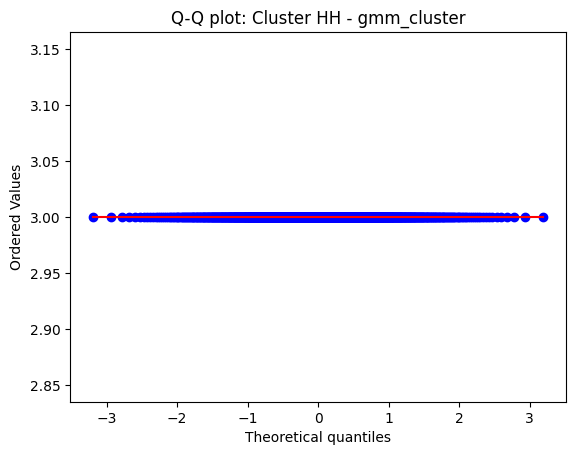

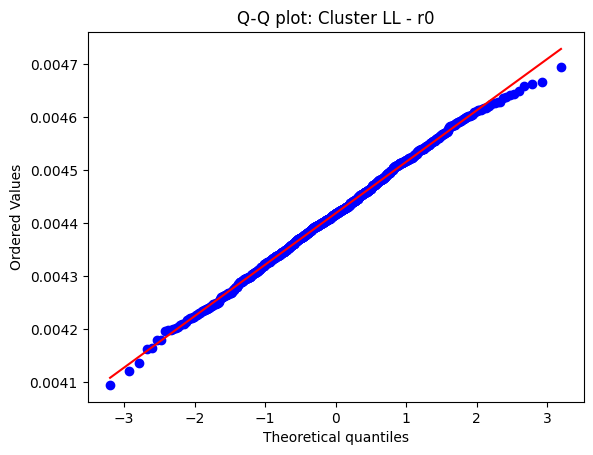

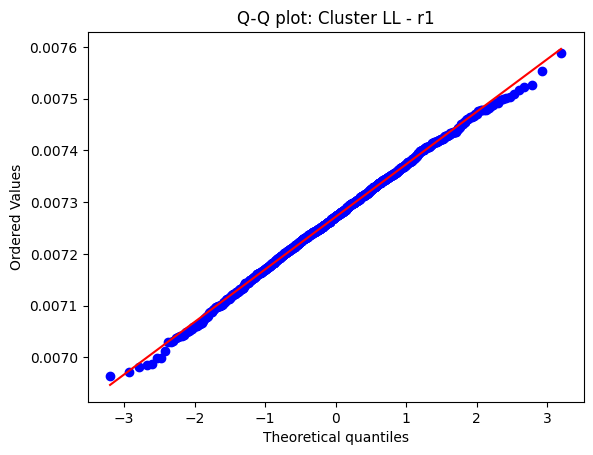

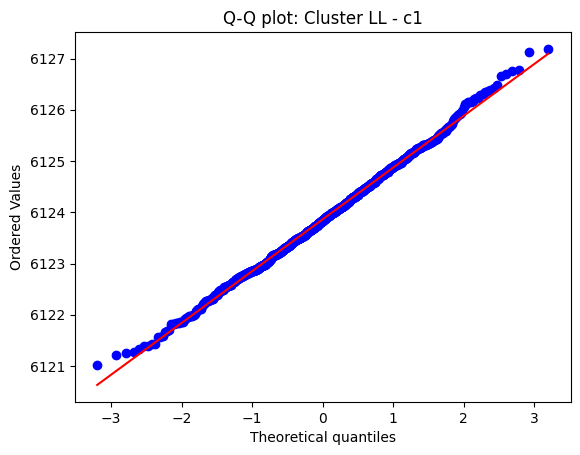

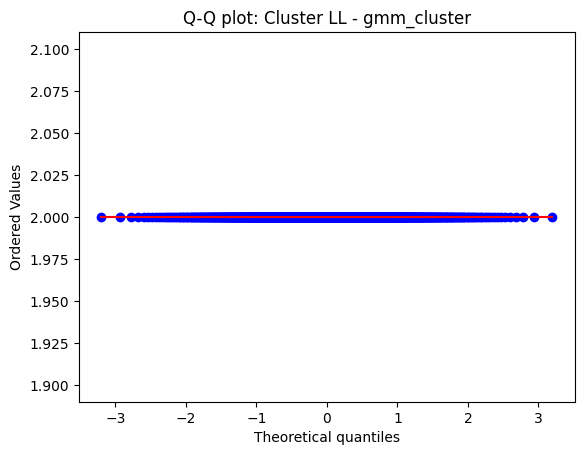

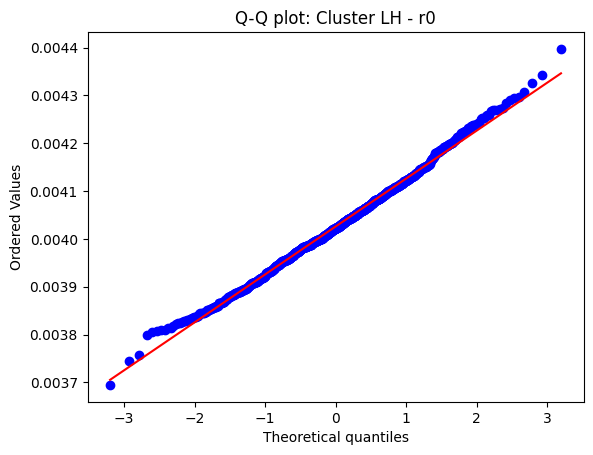

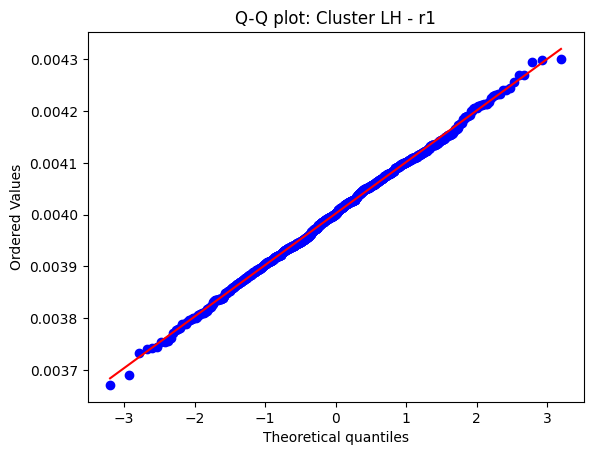

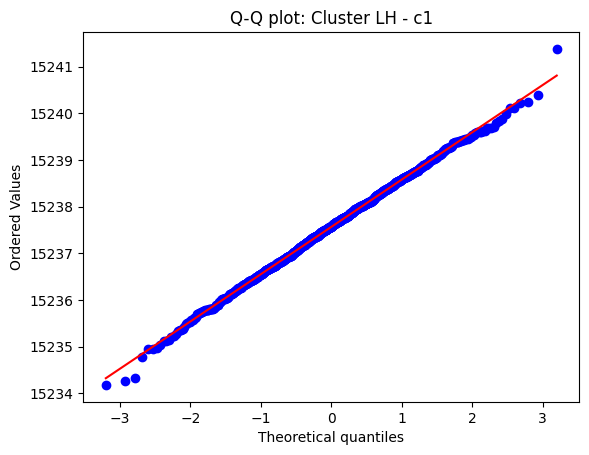

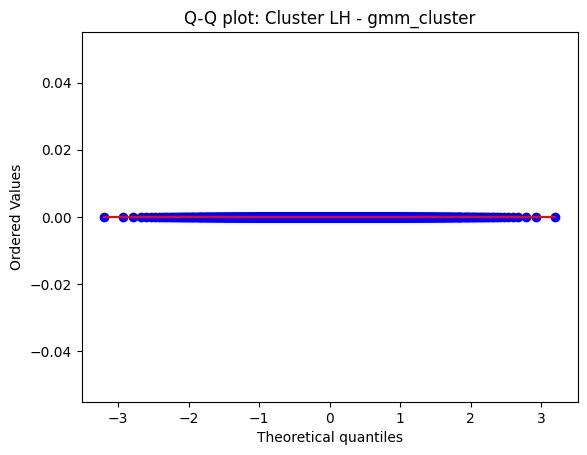

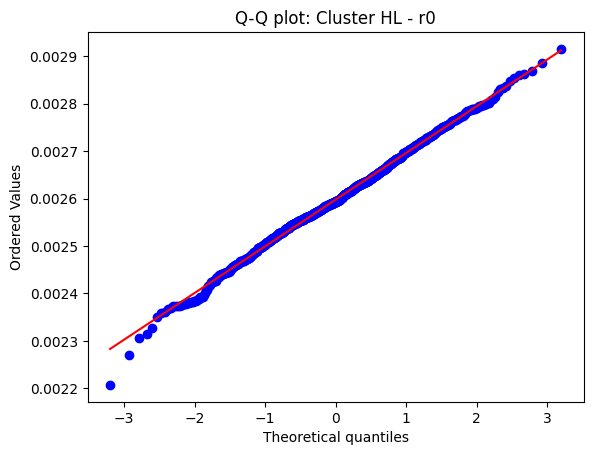

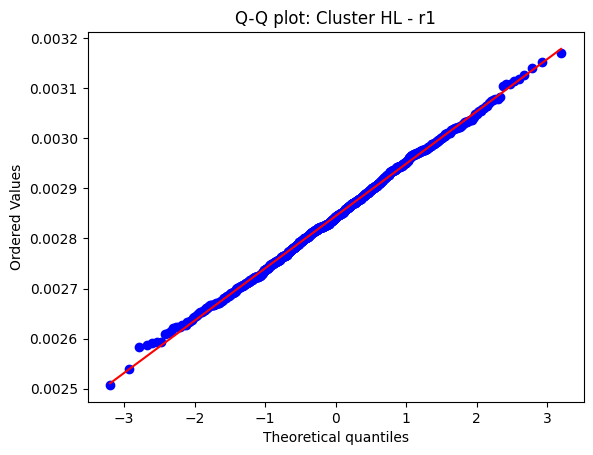

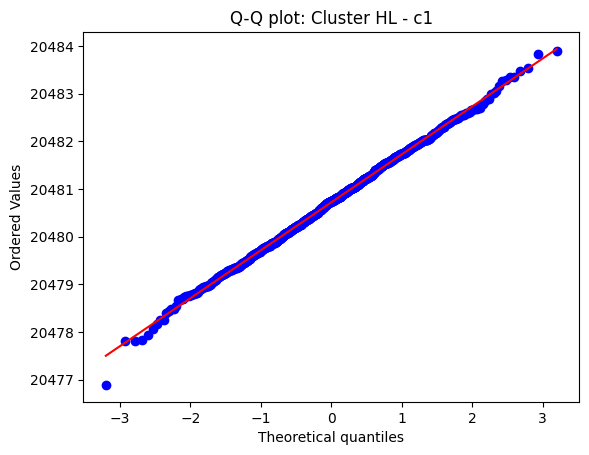

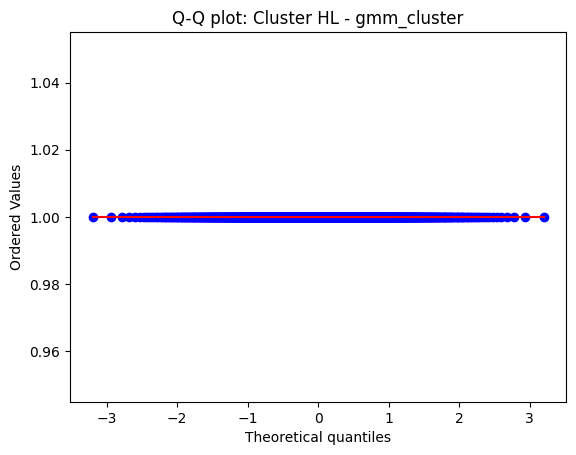

In [289]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot

for label in df['region'].unique():
    subset = df[df['region'] == label].drop(columns=['region'])
    for col in subset.columns:
        plt.figure()
        probplot(subset[col], dist="norm", plot=plt)
        plt.title(f'Q-Q plot: Cluster {label} - {col}')